In [1]:
import sys
import os
import numpy as np
import tqdm

import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.optim as optim

#from torch.autograd import Variable
#from torch.nn import Module, Sequential, Conv2d # for helper functions

import matplotlib.pyplot as plt
#from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Dataset
#from torchvision import datasets, transforms
#from torchvision.utils import save_image

import h5py
from torchsummary import summary

In [2]:
from pyMSDtorch.core import helpers
from pyMSDtorch.core.networks import MSDNet
#from pyMSDtorch.test_data import threeD 
from pyMSDtorch.test_data.twoD import build_test_data, torch_hdf5_loader

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

#from pytorch_lightning.metrics.functional import accuracy

In [3]:
### Some Parameters to Define ###
#################################

makeData = True     # Set makeData=1 to produce and save to hdf5 file, set 
                    # to zero to load.
time_point = 0      # Number of time slices to use; set to None to take all. 
                    # Length defines number of input channels to MSDNet later
batch_size = 32
num_workers = 8

showNoisyData = True
use_scaled_data = True

In [4]:
save_directory = 'DenoisingResults'
helpers.make_dir(save_directory)

## Data generation toggles
- SNR dictates noise level (10+ easy, 5 medium, 2~3 hard, <1 impossible)

In [5]:
### Generate Data ###
#####################

if makeData == True:
    N_imgs = 500 
    N_peaks = 3
    N_xy = 32
    SNR=3
    mask_radius = 1.0
    
    build_test_data.build_data_standard_sets_2d(N_imgs=N_imgs,
                                                N_peaks=N_peaks,
                                                N_xy=N_xy,
                                                SNR=SNR,
                                                mask_radius=mask_radius)

100%|██████████| 1/1 [00:00<00:00, 72.68it/s]


## Load data

Data generator class above can generate the following:
- trax_GT -- ground truth
- trax_obs -- obstructed, noisy images
- trax_obs_norm -- noisy images linearly scaled to interal [0,1]
- trax_mask -- binary masked images indicating peak (1) or background (0)

In [6]:
### Load Data ###
#################

if use_scaled_data == True:
    x_label = "trax_obs_norm"
else:
    x_label = "trax_obs"
    
f_train = "train_data_2d.hdf5"
f_test  = "test_data_2d.hdf5"
f_validation = "validate_data_2d.hdf5"

MyData_train = torch_hdf5_loader.Hdf5Dataset2D(filename=f_train, 
                                                  x_label=x_label, 
                                                  y_label="trax_GT")
MyData_validation = torch_hdf5_loader.Hdf5Dataset2D(filename=f_validation, 
                                                       x_label=x_label, 
                                                       y_label="trax_GT")
MyData_test = torch_hdf5_loader.Hdf5Dataset2D(filename=f_test, 
                                                 x_label=x_label, 
                                                 y_label="trax_GT")

loader_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_workers}
train_loader = DataLoader(MyData_train, **loader_params)
validation_loader = DataLoader(MyData_validation, **loader_params)
test_loader = DataLoader(MyData_test, **loader_params)

tensor(1.) tensor(1.5351)


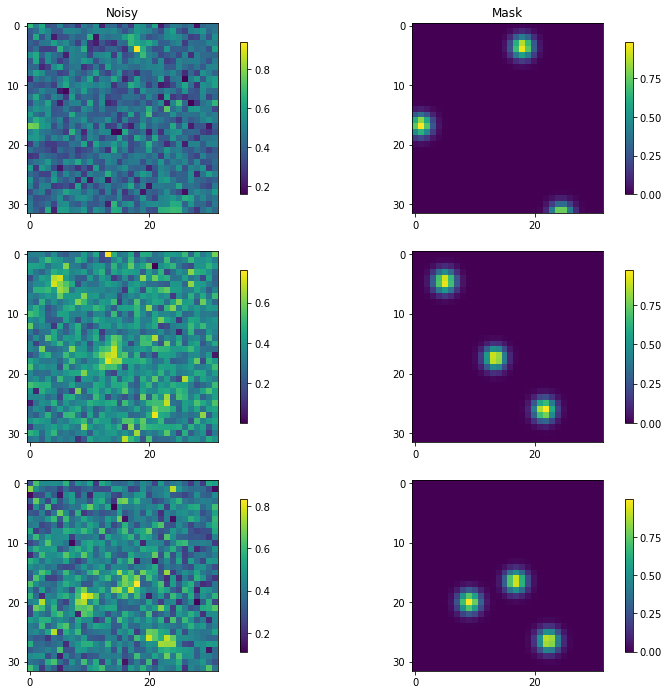

In [7]:
### Show Noisy Data ###
#######################
        
if showNoisyData == True:
    for batch in train_loader:
        noisy, mask = batch
                
        print(torch.max(noisy), torch.max(mask))

        plt.figure(figsize=(12,10))
        plt.subplot(321)
        plt.imshow(noisy[0,0,:,:]); plt.colorbar(shrink=0.8); plt.title('Noisy'); 
        plt.subplot(322);
        plt.imshow(mask[0,0,:,:]); plt.colorbar(shrink=0.8); plt.title('Mask'); 
        plt.subplot(323)
        plt.imshow(noisy[1,0,:,:]); plt.colorbar(shrink=0.8)
        plt.subplot(324);
        plt.imshow(mask[1,0,:,:]); plt.colorbar(shrink=0.8) 
        plt.subplot(325)
        plt.imshow(noisy[2,0,:,:]); plt.colorbar(shrink=0.8)
        plt.subplot(326);
        plt.imshow(mask[2,0,:,:]); plt.colorbar(shrink=0.8) 

        break
        
    plt.rcParams.update({'font.size': 18})
    plt.tight_layout()
    save_name = save_directory + '/Noisy_vs_mask'
    plt.savefig(save_name)
    plt.show()

## Create mixed-scale dense convolutional neural network

Lots of options to customize. See pyMSDtorch/core/networks/MSDNet.py 

In [8]:
### Build Networks ###
#####################

#N_xyz=20
in_channels = 1
out_channels = 1
num_layers = 20             # Benchmarks used 100, 150, and 200
layer_width = 1    # Usually 1
max_dilation = 10           # Set to 10 in Pelt, Sethian paper
activation = nn.ReLU()
normalization = nn.BatchNorm2d
#final_layer = nn.Sigmoid()
final_layer = None
#dropout = np.array([0,0,0]) # Not useful, literature

net = MSDNet.MixedScaleDenseNetwork(in_channels = in_channels,
                                      out_channels = out_channels, 
                                      num_layers=num_layers, 
                                      layer_width=layer_width,
                                      max_dilation = max_dilation, 
                                      activation=activation,
                                      normalization=normalization,
                                      final_layer=final_layer,
                                      convolution=nn.Conv2d
                                   )
#print(net)
summary(net, (in_channels, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 32, 32]              10
MixedScaleDenseLayer-2            [-1, 2, 32, 32]               0
              ReLU-3            [-1, 2, 32, 32]               0
       BatchNorm2d-4            [-1, 2, 32, 32]               4
            Conv2d-5            [-1, 1, 32, 32]              19
MixedScaleDenseLayer-6            [-1, 3, 32, 32]               0
              ReLU-7            [-1, 3, 32, 32]               0
       BatchNorm2d-8            [-1, 3, 32, 32]               6
            Conv2d-9            [-1, 1, 32, 32]              28
MixedScaleDenseLayer-10            [-1, 4, 32, 32]               0
             ReLU-11            [-1, 4, 32, 32]               0
      BatchNorm2d-12            [-1, 4, 32, 32]               8
           Conv2d-13            [-1, 1, 32, 32]              37
MixedScaleDenseLayer-14         

/home/ejroberts/anaconda3/envs/MSDNet/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370151529/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Define training loop

Each loop iteration performs the following:

- Loads training data from train_loader, casts data as a tensor of floats, and sends data to specified device
- Runs noisy data through network, backpropgates, then updates parameters
- Loads validation set and passes it through network
- With torch.no_grad(), we leave gradient calculations and network parameters alone

In [9]:
def train2d(net, trainloader, validationloader, NUM_EPOCHS, path):
    
    train_loss = []
    validation_loss = []
    for epoch in range(NUM_EPOCHS):
        running_train_loss = 0.0
        running_validation_loss = 0.0

        for data in trainloader:
            noisy, target = data   # load noisy and clean images from loader

            noisy = noisy.type(torch.FloatTensor)
            target = target.type(torch.FloatTensor)
            noisy = noisy.to(device)
            target = target.to(device)
            
            # forward pass
            output = net(noisy)
            loss = criterion(output, target)
            
            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            
            # update the parameters
            optimizer.step()
            running_train_loss += loss.item()
            
        # compute validation step
        with torch.no_grad():
            net.eval()
            for x,y in validationloader:
                x = x.to(device)
                y = y.to(device)
                            
                #print('x max: ', torch.max(x))
                #x = x / torch.max(x)
                #y = y / torch.max(y)

                # forward pass, compute validation loss and accuracy
                #net.eval()                
                yhat = net(x)
                val_loss = criterion(yhat, y)
                
                # update running validation loss and accuracy 
                running_validation_loss += val_loss.item()
            net.train()
        
        loss = running_train_loss / len(trainloader)
        val_loss = running_validation_loss / len(validationloader)

        train_loss.append(loss)
        validation_loss.append(val_loss)
        
        # print status and save cleaned images
        print(f'Epoch {epoch + 1} of {NUM_EPOCHS} | Training Loss: {loss:.4f} | Validation Loss: {val_loss:.4f}')

        
        ## Save clean, noisy, and output images below
        if np.mod(epoch+1,10) == 0:
            print('### Random Training Images ###')
            helpers.save_training_images(noisy.cpu()[0,0,:,:], output.cpu()[0,0,:,:], target.cpu()[0,0,:,:],
                                        path, epoch, train=True)

            print('### Random Validation Images ###')
            helpers.save_training_images(x.cpu()[0,0,:,:], yhat.cpu()[0,0,:,:], y.cpu()[0,0,:,:],
                                        path, epoch, train=False)
    return net, train_loss, validation_loss

In [10]:
criterion = nn.MSELoss()

LEARNING_RATE = 1e-2

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

## Train the model

- We set path for saving results, 
- specify number of epochs,
- retrieve device for computing ('cpu' or 'cuda:0' for GPU)
- and train using defined training loop

cpu
Epoch 1 of 31 | Training Loss: 0.0813 | Validation Loss: 0.0137
Epoch 2 of 31 | Training Loss: 0.0107 | Validation Loss: 0.0113
Epoch 3 of 31 | Training Loss: 0.0074 | Validation Loss: 0.0067
Epoch 4 of 31 | Training Loss: 0.0063 | Validation Loss: 0.0064
Epoch 5 of 31 | Training Loss: 0.0056 | Validation Loss: 0.0063
Epoch 6 of 31 | Training Loss: 0.0052 | Validation Loss: 0.0057
Epoch 7 of 31 | Training Loss: 0.0047 | Validation Loss: 0.0052
Epoch 8 of 31 | Training Loss: 0.0044 | Validation Loss: 0.0048
Epoch 9 of 31 | Training Loss: 0.0042 | Validation Loss: 0.0043
Epoch 10 of 31 | Training Loss: 0.0040 | Validation Loss: 0.0040
### Random Training Images ###


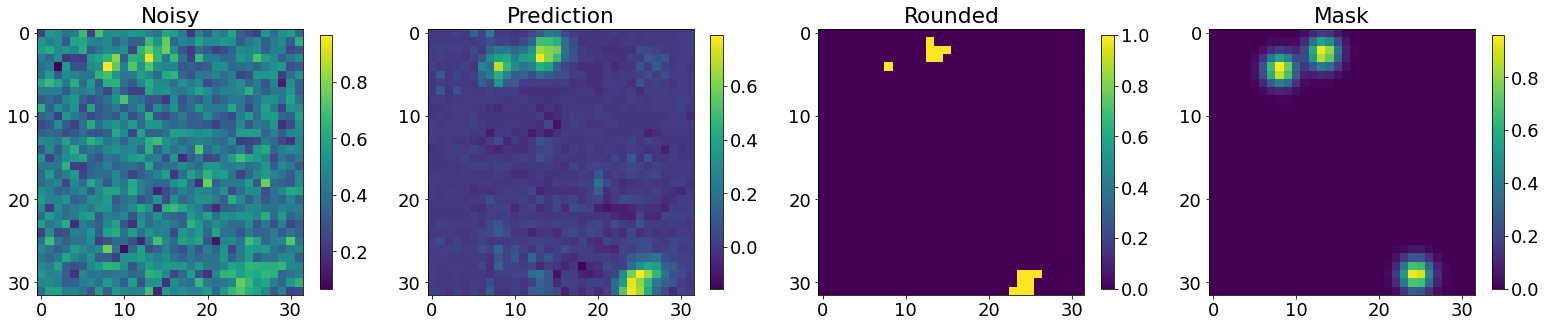

### Random Validation Images ###


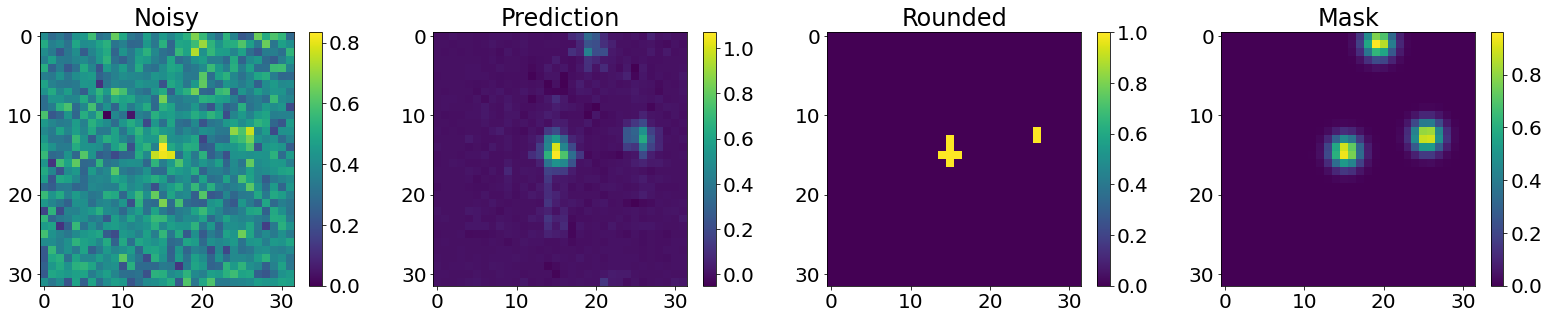

Epoch 11 of 31 | Training Loss: 0.0038 | Validation Loss: 0.0040
Epoch 12 of 31 | Training Loss: 0.0036 | Validation Loss: 0.0040
Epoch 13 of 31 | Training Loss: 0.0035 | Validation Loss: 0.0037
Epoch 14 of 31 | Training Loss: 0.0034 | Validation Loss: 0.0036
Epoch 15 of 31 | Training Loss: 0.0033 | Validation Loss: 0.0036
Epoch 16 of 31 | Training Loss: 0.0032 | Validation Loss: 0.0034
Epoch 17 of 31 | Training Loss: 0.0031 | Validation Loss: 0.0034
Epoch 18 of 31 | Training Loss: 0.0029 | Validation Loss: 0.0030
Epoch 19 of 31 | Training Loss: 0.0028 | Validation Loss: 0.0031
Epoch 20 of 31 | Training Loss: 0.0027 | Validation Loss: 0.0029
### Random Training Images ###


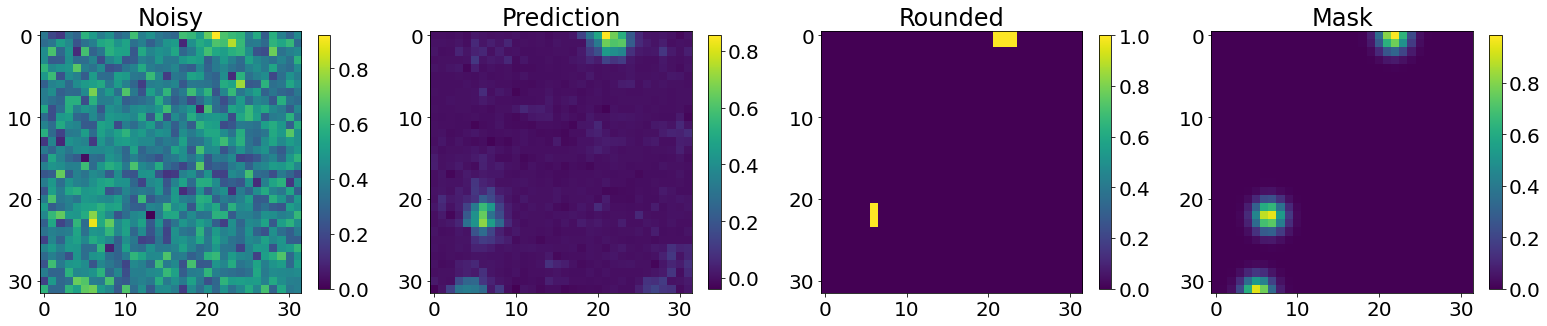

### Random Validation Images ###


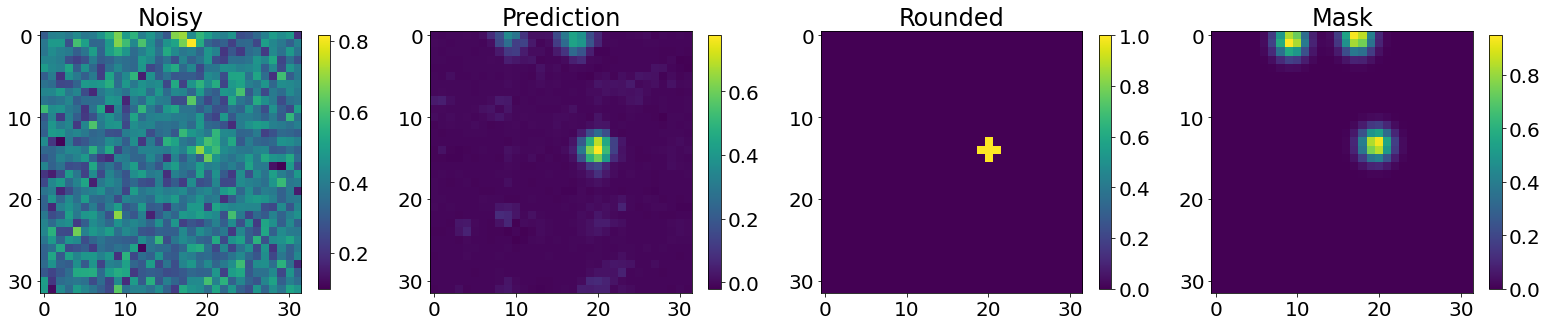

Epoch 21 of 31 | Training Loss: 0.0027 | Validation Loss: 0.0029
Epoch 22 of 31 | Training Loss: 0.0026 | Validation Loss: 0.0027
Epoch 23 of 31 | Training Loss: 0.0025 | Validation Loss: 0.0026
Epoch 24 of 31 | Training Loss: 0.0024 | Validation Loss: 0.0028
Epoch 25 of 31 | Training Loss: 0.0023 | Validation Loss: 0.0026
Epoch 26 of 31 | Training Loss: 0.0022 | Validation Loss: 0.0025
Epoch 27 of 31 | Training Loss: 0.0022 | Validation Loss: 0.0025
Epoch 28 of 31 | Training Loss: 0.0022 | Validation Loss: 0.0025
Epoch 29 of 31 | Training Loss: 0.0021 | Validation Loss: 0.0025
Epoch 30 of 31 | Training Loss: 0.0021 | Validation Loss: 0.0023
### Random Training Images ###


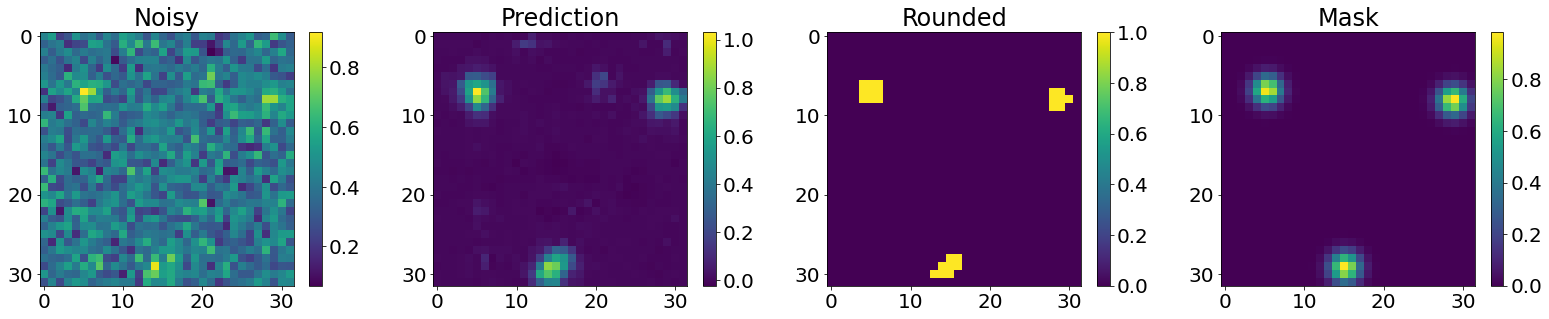

### Random Validation Images ###


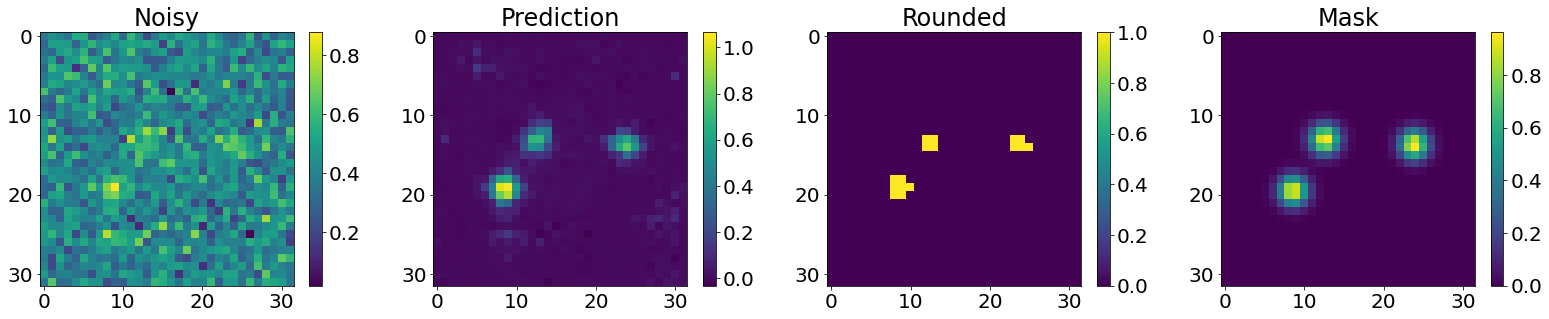

Epoch 31 of 31 | Training Loss: 0.0021 | Validation Loss: 0.0023


In [11]:
#thisfolder = 'full2d'
path = save_directory #+ thisfolder
#helpers.make_dir(path)


NUM_EPOCHS = 31   # set number of epochs

device = helpers.get_device()
print(device)
net.to(device)

net, train_loss, validation_loss = train2d(net, 
                                           train_loader, 
                                           validation_loader, 
                                           NUM_EPOCHS,
                                           path)   # training happens here


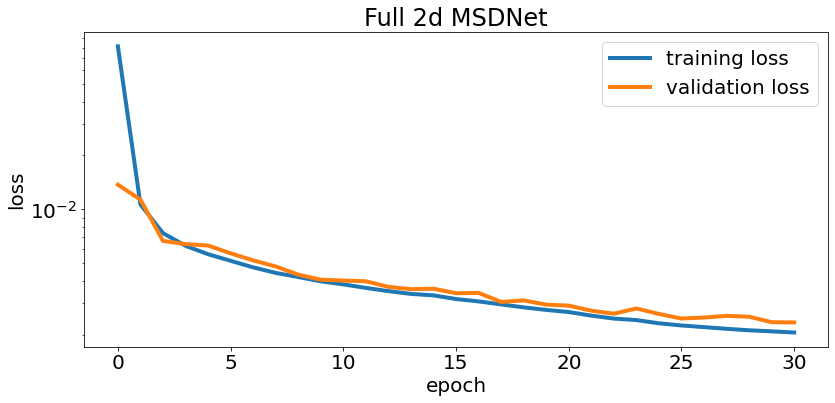

In [12]:
plt.figure(figsize=(12,6))
plt.plot(train_loss,linewidth=4, label='training loss')
plt.plot(validation_loss,linewidth=4, label='validation loss')
plt.yscale('log')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Full 2d MSDNet')
plt.tight_layout()
plt.savefig(path + '/loss_summary.png')

## Saving network and testing our model

- Below, we save model parameters using torch.save
    - You have option of saving full model, but save parameters and loading them into a newly instantiated network is more flexible

- Finally, we load testing data, pass it through the network, and save results as .png

In [13]:
torch.save(net.state_dict(), save_directory + '/net')

np.savez('./'+save_directory + '/loss_accuracy_arrays', 
         train_loss=train_loss, 
         validation_loss=validation_loss
        )

In [14]:
### Reconstruct Testing Data ###
################################\

test_folder = '/testing'
save_directory_test = save_directory + test_folder
helpers.make_dir(save_directory_test)  

counter = 0
net.eval()
for batch in test_loader:
    #running_test_acc = 0.0
    
    noisy, target = batch
    
    noisy = noisy.type(torch.FloatTensor)
    target = target.type(torch.FloatTensor)
    noisy = noisy.to(device)
    target = target.to(device)

    output = net(noisy)
    #rounded = torch.round(output)
    
    #test_acc = helpers.binary_acc(output, target)
    #running_test_acc += test_acc.item()
        
    # Scale noisy down for plotting purposes
    noisy = noisy/torch.max(noisy)

    noisy_name  = './' + save_directory_test + '/noisy{}.png'.format(counter)
    output_name1 = './' + save_directory_test + '/output{}.png'.format(counter)
    target_name1  = './' + save_directory_test + '/target{}.png'.format(counter)
    helpers.save_decoded_image2d(noisy.cpu().data, name=noisy_name)
    helpers.save_decoded_image2d(output.cpu()[:,0,:,:].data, name=output_name1)
    helpers.save_decoded_image2d(target.cpu()[:,0,:,:].data, name=target_name1)
    
    counter += 1
net.train
#test_acc = running_test_acc / len(test_loader)
#print('Final testing accuracy is :', test_acc)

<bound method Module.train of MixedScaleDenseNetwork(
  (layer_0): MixedScaleDenseLayer(
    (conv_0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (activation_0): ReLU()
  (normalization_0): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_1): MixedScaleDenseLayer(
    (conv_0): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
  )
  (activation_1): ReLU()
  (normalization_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_2): MixedScaleDenseLayer(
    (conv_0): Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), dilation=(3, 3))
  )
  (activation_2): ReLU()
  (normalization_2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer_3): MixedScaleDenseLayer(
    (conv_0): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(4, 4), dilation=(4, 4))
  )
  (activation_3): ReLU()
  (normalization_3): BatchN